<a href="https://colab.research.google.com/github/Bibhash123/JSTARS-NESNet/blob/main/Validation_%26_Benchmarking/SO2_and_O3_validation_plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle
from google.colab import files
_ = files.upload()
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d bibhash123/so2estimation
!unzip so2estimation.zip -d "/content/SO2dataset"
!rm so2estimation.zip

!kaggle datasets download -d bibhash123/o3estimation
!unzip o3estimation.zip -d "/content/O3dataset"
!rm o3estimation.zip
from IPython.display import clear_output
clear_output(wait=False)

In [ ]:
!pip uninstall -y shapely
!pip uninstall -y cartopy
!pip install shapely cartopy --no-binary shapely --no-binary cartopy
clear_output(wait=False)

In [ ]:
import numpy as np
import random
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import os
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split,KFold
# import utils
import gc

SEED=123
def seedAll(seed):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  os.environ["PYTHONHASHSEED"]=str(seed)

seedAll(SEED)

In [ ]:
files = pd.read_csv("/content/SO2dataset/files.csv").sample(frac=1).reset_index(drop=True)
files.drop("Fold",axis=1,inplace=True)

In [ ]:
def loadData(df,satdir = "/content/SO2dataset/satellite/",gdir = "/content/SO2dataset/ground/"):
  X = []
  Y = []
  for i in range(df.shape[0]):
    factor = 46*(6.02214/6.023)*1e2
    sat = np.expand_dims(factor*np.load(os.path.join(satdir,df["SatFile"].iloc[i])),axis=2)      
    ground = np.load(os.path.join(gdir,df["GroundFile"].iloc[i])).flatten()
    if not np.isnan(np.sum(sat)) and not np.isnan(np.sum(ground)):
      if not np.std(ground)==0:
        X.append(sat)
        Y.append(ground)
  return np.stack(X,axis=0),np.stack(Y,axis=0)

In [ ]:
def build_model(X_train,num_layers_16=1):
  inp = L.Input(shape=X_train[0].shape)
  if num_layers_16>=1:
    h = L.Conv2D(16,(3,3),activation="linear",padding="same")(inp)
    for j in range(num_layers_16-1):
      h = L.Conv2D(16,(3,3),activation="linear")(h)
      if j%3==0:
        h = L.MaxPooling2D(pool_size=(2,2),strides=2)(h)

    h = L.Conv2D(32,(3,3),activation="linear")(h)
  else:
    h = L.Conv2D(32,(3,3),activation="linear")(inp)
  out = L.Flatten()(h)
  out = L.Dense(100,activation="linear")(out)
  out = L.Dense(np.prod(X_train[0].shape),activation="linear")(out)
  model = Model(inputs=inp,outputs=out)
  model.compile(optimizer=Adam(learning_rate=0.001),loss="mse",
                metrics=[RootMeanSquaredError()])
  
  return model

In [ ]:
def DataOfFractionSize(df,fraction,n_folds):
  df = df.reset_index(drop=True)
  mask = [False for _ in range(len(df))]

  indices = np.random.choice(list(df.index),int(len(df)*fraction),replace=False)
  for index in indices:
    mask[index]=True
  df = df.loc[mask,:].reset_index(drop=True)

  kf = KFold(n_splits = n_folds,shuffle=True)
  df.loc[:,'Fold'] = -1
  for idx,(trn_,val_) in enumerate(kf.split(df)):
    df.loc[val_,'Fold'] = idx

  return df

In [ ]:
def trainFunction(df,n_folds):
  rmses=[]
  for fold in range(n_folds):
    train_files = df[df["Fold"]!=fold]
    val_files = df[df["Fold"]==fold]

    X_train,Y_train = loadData(train_files)
    X_val,Y_val = loadData(val_files)
    # loss_plt = utils.loss_plt()
    K.clear_session()
    model = build_model(X_train,num_layers_16 = 3)
    
    ckpt = ModelCheckpoint(f"model_{fold}.hdf5",monitor="val_root_mean_squared_error",mode="min",save_best_only=True,save_weights_only=True)
    model.fit(X_train,Y_train,
              epochs=50,
              verbose=0,
              batch_size=8,
              validation_data = (X_val,Y_val),
              callbacks=[ckpt]
              )
    model.load_weights(f"model_{fold}.hdf5")
    rmse = mean_squared_error(Y_val,model.predict(X_val),squared=False)
    rmses.append(rmse)
    del model
    _ = gc.collect()
  print("RMSE Score: {}".format(np.mean(rmses)))
  return np.mean(rmses)

In [ ]:
EXP_PER_SIZE = 20
N_FOLDS = 3
FRACTIONS = np.arange(0.1,1.1,0.1)

In [ ]:
frac_vs_rmse = {}
for frac in FRACTIONS:
  print("\nTraining for {} % Dataset\n".format(int(frac*100)))
  exp_rmses = []
  for idx in range(EXP_PER_SIZE):
    print(f"Exp {idx+1}")
    exp_df = DataOfFractionSize(files,frac,N_FOLDS)
    exp_rmses.append(trainFunction(exp_df,N_FOLDS))
  frac_vs_rmse[frac] = exp_rmses


Training for 10 % Dataset

Exp 1
RMSE Score: 5.837070528737943
Exp 2
RMSE Score: 7.017046360553766
Exp 3
RMSE Score: 7.3813469948998245
Exp 4
RMSE Score: 4.747309257305026
Exp 5
RMSE Score: 7.5252047950904455
Exp 6
RMSE Score: 5.743123542873477
Exp 7
RMSE Score: 5.9286677542688615
Exp 8
RMSE Score: 8.781383735431646
Exp 9
RMSE Score: 6.815502959530918
Exp 10
RMSE Score: 5.998193060173638
Exp 11
RMSE Score: 5.999140011518939
Exp 12
RMSE Score: 6.746251153696977
Exp 13
RMSE Score: 6.55902728376185
Exp 14
RMSE Score: 7.936529036824965
Exp 15
RMSE Score: 5.651066690640881
Exp 16
RMSE Score: 7.29306736267364
Exp 17
RMSE Score: 6.0798769660880145
Exp 18
RMSE Score: 7.912345711105207
Exp 19
RMSE Score: 6.703897649850828
Exp 20
RMSE Score: 7.37884850050698

Training for 20 % Dataset

Exp 1
RMSE Score: 7.861683443467631
Exp 2
RMSE Score: 5.612891141624332
Exp 3
RMSE Score: 6.678227138485506
Exp 4
RMSE Score: 5.0317607694345945
Exp 5
RMSE Score: 5.404623346494432
Exp 6
RMSE Score: 6.66429291375

In [ ]:
p_data = []
scores = []
for p in FRACTIONS:
  score_ls = frac_vs_rmse[p]
  p_data.extend([int(p*100) for _ in range(len(score_ls))])
  scores.extend(score_ls)
results = pd.DataFrame({"Percentage of Data":p_data,"RMSE Scores":scores})

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


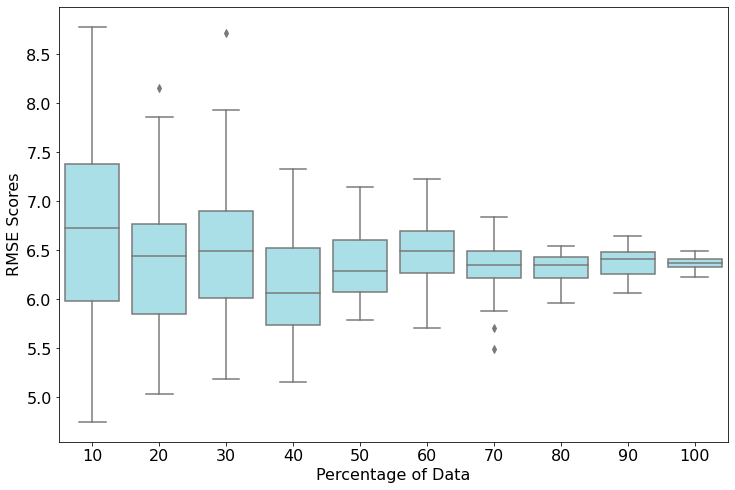

In [ ]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["font.size"] = 16
fig = plt.figure(figsize=(12,8))
sns.boxplot(x='Percentage of Data', y= 'RMSE Scores', data = results, color=(160/255, 231/255, 242/255))

In [ ]:
fig.savefig("SO2_rmse_data.pdf")

In [ ]:
for p in results["Percentage of Data"].unique():
  print("Percentage: ",p)
  temp_df = results[results["Percentage of Data"]==p]
  print("Mean: ",np.mean(temp_df["RMSE Scores"]))
  print("IQR: ",np.percentile(temp_df["RMSE Scores"], 75, interpolation = 'midpoint')-np.percentile(temp_df["RMSE Scores"], 25, interpolation = 'midpoint'))
  print('')

Percentage:  10
Mean:  6.7017449677766905
IQR:  1.416667340482153

Percentage:  20
Mean:  6.4573682747836
IQR:  1.0550881575613182

Percentage:  30
Mean:  6.574725170082379
IQR:  0.8978783188077379

Percentage:  40
Mean:  6.144734915638649
IQR:  0.8242936654832125

Percentage:  50
Mean:  6.371864587525206
IQR:  0.5648093603471

Percentage:  60
Mean:  6.429023677865182
IQR:  0.4388573328440337

Percentage:  70
Mean:  6.32041816546045
IQR:  0.30052151155470774

Percentage:  80
Mean:  6.314756810621935
IQR:  0.22163996510148198

Percentage:  90
Mean:  6.376995331388734
IQR:  0.23013539064701583

Percentage:  100
Mean:  6.370822358231626
IQR:  0.0849988017184442



# O3

In [ ]:
files = pd.read_csv("/content/O3dataset/files.csv").sample(frac=1).reset_index(drop=True)
files.drop("Fold",axis=1,inplace=True)

In [ ]:
def loadData(df,satdir = "/content/O3dataset/satellite/",gdir = "/content/O3dataset/ground/"):
  X = []
  Y = []
  for i in range(df.shape[0]):
    factor = 46*(6.02214/6.023)*1e2
    sat = np.expand_dims(factor*np.load(os.path.join(satdir,df["SatFile"].iloc[i])),axis=2)      
    ground = np.load(os.path.join(gdir,df["GroundFile"].iloc[i])).flatten()
    if not np.isnan(np.sum(sat)) and not np.isnan(np.sum(ground)):
      if not np.std(ground)==0:
        X.append(sat)
        Y.append(ground)
  return np.stack(X,axis=0),np.stack(Y,axis=0)

In [ ]:
def build_model(X_train,num_layers_16=1):
  inp = L.Input(shape=X_train[0].shape)
  if num_layers_16>=1:
    h = L.Conv2D(16,(3,3),activation="linear",padding="same")(inp)
    for j in range(num_layers_16-1):
      h = L.Conv2D(16,(3,3),activation="linear")(h)
      if j%3==0:
        h = L.MaxPooling2D(pool_size=(2,2),strides=2)(h)

    h = L.Conv2D(32,(3,3),activation="linear")(h)
  else:
    h = L.Conv2D(32,(3,3),activation="linear")(inp)
  out = L.Flatten()(h)
  out = L.Dense(100,activation="linear")(out)
  out = L.Dense(np.prod(X_train[0].shape),activation="linear")(out)
  model = Model(inputs=inp,outputs=out)
  model.compile(optimizer=Adam(learning_rate=0.001),loss="mse",
                metrics=[RootMeanSquaredError()])
  
  return model

In [ ]:
def DataOfFractionSize(df,fraction,n_folds):
  df = df.reset_index(drop=True)
  mask = [False for _ in range(len(df))]

  indices = np.random.choice(list(df.index),int(len(df)*fraction),replace=False)
  for index in indices:
    mask[index]=True
  df = df.loc[mask,:].reset_index(drop=True)

  kf = KFold(n_splits = n_folds,shuffle=True)
  df.loc[:,'Fold'] = -1
  for idx,(trn_,val_) in enumerate(kf.split(df)):
    df.loc[val_,'Fold'] = idx

  return df

In [ ]:
def trainFunction(df,n_folds):
  rmses=[]
  for fold in range(n_folds):
    train_files = df[df["Fold"]!=fold]
    val_files = df[df["Fold"]==fold]

    X_train,Y_train = loadData(train_files)
    X_val,Y_val = loadData(val_files)
    # loss_plt = utils.loss_plt()
    K.clear_session()
    model = build_model(X_train,num_layers_16 = 3)
    
    ckpt = ModelCheckpoint(f"model_{fold}.hdf5",monitor="val_root_mean_squared_error",mode="min",save_best_only=True,save_weights_only=True)
    model.fit(X_train,Y_train,
              epochs=50,
              verbose=0,
              batch_size=8,
              validation_data = (X_val,Y_val),
              callbacks=[ckpt]
              )
    model.load_weights(f"model_{fold}.hdf5")
    rmse = mean_squared_error(Y_val,model.predict(X_val),squared=False)
    rmses.append(rmse)
    del model
    _ = gc.collect()
  print("RMSE Score: {}".format(np.mean(rmses)))
  return np.mean(rmses)

In [ ]:
EXP_PER_SIZE = 20
N_FOLDS = 3
FRACTIONS = np.arange(0.1,1.1,0.1)

In [ ]:
frac_vs_rmse = {}
for frac in FRACTIONS:
  print("\nTraining for {} % Dataset\n".format(int(frac*100)))
  exp_rmses = []
  for idx in range(EXP_PER_SIZE):
    print(f"Exp {idx+1}")
    exp_df = DataOfFractionSize(files,frac,N_FOLDS)
    exp_rmses.append(trainFunction(exp_df,N_FOLDS))
  frac_vs_rmse[frac] = exp_rmses


Training for 10 % Dataset

Exp 1
RMSE Score: 15.084333476447886
Exp 2
RMSE Score: 17.783058774242818
Exp 3
RMSE Score: 14.339108973350855
Exp 4
RMSE Score: 14.620913473576286
Exp 5
RMSE Score: 15.293780141426204
Exp 6
RMSE Score: 15.315081155533873
Exp 7
RMSE Score: 18.132581006074172
Exp 8
RMSE Score: 18.319732689555444
Exp 9
RMSE Score: 17.072025632273363
Exp 10
RMSE Score: 16.8755878009775
Exp 11
RMSE Score: 16.151910063175084
Exp 12
RMSE Score: 16.239873776790493
Exp 13
RMSE Score: 16.592408040245108
Exp 14
RMSE Score: 15.964352183265026
Exp 15
RMSE Score: 16.81301393447997
Exp 16
RMSE Score: 13.922522459461959
Exp 17
RMSE Score: 15.504739372630823
Exp 18
RMSE Score: 17.11254769862543
Exp 19
RMSE Score: 15.284206529782152
Exp 20
RMSE Score: 17.66941429343352

Training for 20 % Dataset

Exp 1
RMSE Score: 15.516587549106918
Exp 2
RMSE Score: 14.688282238612574
Exp 3
RMSE Score: 15.612508882291154
Exp 4
RMSE Score: 15.274285715021648
Exp 5
RMSE Score: 15.858543729283186
Exp 6
RMSE Sc

In [ ]:
p_data = []
scores = []
for p in FRACTIONS:
  score_ls = frac_vs_rmse[p]
  p_data.extend([int(p*100) for _ in range(len(score_ls))])
  scores.extend(score_ls)
results = pd.DataFrame({"Percentage of Data":p_data,"RMSE Scores":scores})

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


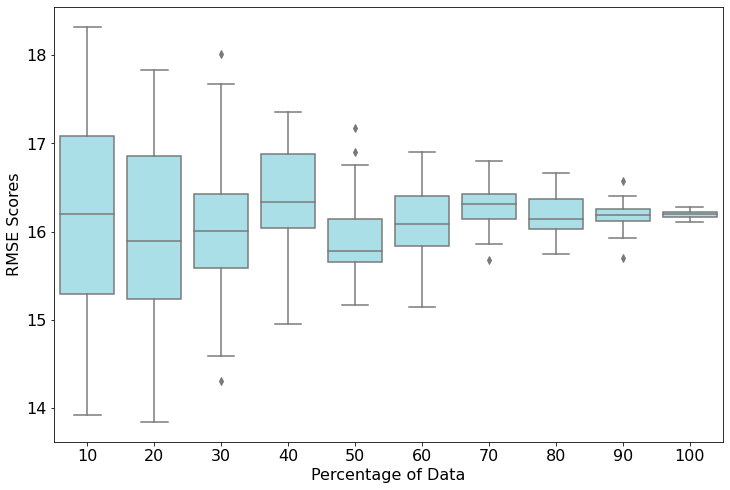

In [ ]:
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["font.size"] = 16
fig = plt.figure(figsize=(12,8))
sns.boxplot(x='Percentage of Data', y= 'RMSE Scores', data = results, color=(160/255, 231/255, 242/255))

In [ ]:
fig.savefig("O3_rmse_data.pdf")

In [ ]:
for p in results["Percentage of Data"].unique():
  print("Percentage: ",p)
  temp_df = results[results["Percentage of Data"]==p]
  print("Mean: ",np.mean(temp_df["RMSE Scores"]))
  print("IQR: ",np.percentile(temp_df["RMSE Scores"], 75, interpolation = 'midpoint')-np.percentile(temp_df["RMSE Scores"], 25, interpolation = 'midpoint'))
  print('')

Percentage:  10
Mean:  16.204559573767394
IQR:  1.8032933298452178

Percentage:  20
Mean:  15.968868562306906
IQR:  1.710133789956128

Percentage:  30
Mean:  16.044358189074188
IQR:  0.9472815534280592

Percentage:  40
Mean:  16.432508777281786
IQR:  0.8523055491918399

Percentage:  50
Mean:  15.974067591520441
IQR:  0.6097295831092922

Percentage:  60
Mean:  16.119231994088064
IQR:  0.6021520972505812

Percentage:  70
Mean:  16.277034478957624
IQR:  0.31689498556040974

Percentage:  80
Mean:  16.203423610020298
IQR:  0.3647823436263593

Percentage:  90
Mean:  16.185105416028954
IQR:  0.14062583914491

Percentage:  100
Mean:  16.193520183897316
IQR:  0.06499859138103758

